In [196]:
import pandas as pd
import os
import glob
import numpy as np
from snorkel.labeling.model import LabelModel, MajorityLabelVoter
from sklearn.metrics import classification_report

def reorder_columns(df, cols_in_front):
    """Reorder columns in a pandas dataframe so that the columns in cols_in_front are in front.
    """
    columns = list(df.columns)
    for col in cols_in_front:
        columns.remove(col)
    columns = cols_in_front + columns
    return df[columns]

def lf_results_reported(path='./CITT/'):
    df = pd.read_csv(path + 'calculated_values.txt', sep='|', low_memory=False)
    df['lf'] = df['were_results_reported'] == 't'
    df['lf'] = df['lf'].astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_num_sponsors(path='./CITT/'):
    df = pd.read_csv(path + 'sponsors.txt', sep='|')
    df = df.groupby('nct_id')['name'].count().reset_index()
    df['lf'] = df['name'] > df['name'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_num_patients(path='./CITT/'):
    df = pd.read_csv(path + 'outcome_counts.txt', sep='|', low_memory=False)    
    df = df.groupby('nct_id').sum().reset_index() # pd df (NCTID, values, num_patients)
    df['lf'] = df['count'] > df['count'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_patient_drop(path='./CITT/'):
    # patient dropout
    df = pd.read_csv(os.path.join(path, 'drop_withdrawals.txt'), sep='|')
    df = df.groupby('nct_id').sum().reset_index() # pd df (NCTID, values, patient_drop)
    df['lf'] = df['count'] < df['count'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_sites(path='./CITT/'):
    # sites
    df = pd.read_csv(os.path.join(path, 'facilities.txt'), sep='|')
    df = df.groupby('nct_id')['name'].count().sort_values(ascending=False).reset_index()
    df = df.groupby('nct_id').mean().reset_index() # pd df (NCTID, values, sites)
    df['lf'] = df['name'] > df['name'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_pvalues(path='./CITT/'):
    # pvalues
    path = './CITT/'
    df = pd.read_csv(os.path.join(path, 'outcome_analyses.txt'), sep='|', low_memory=False)
    df['lf'] = df['p_value'] < .05 # 89406
    df = df.groupby('nct_id')[['lf', 'p_value']].mean().reset_index() # multiple pvalues per nct_id
    df['lf'] = df['lf'] > df['lf'].quantile(.5) 
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_update_more_recent(path='./CITT/'): #TODO clarify what this does
    df = pd.read_csv(os.path.join(path, 'studies.txt'), sep='|', low_memory=False)
    df['last_update_submitted_date'] = pd.to_datetime(df['last_update_submitted_date'])
    df['completion_date'] = pd.to_datetime(df['completion_date'])
    df['update_days'] = (df['last_update_submitted_date'] - df['completion_date']).dt.days
    median = df['update_days'].quantile(.5) 
    # print(median)
    df['lf'] = df['update_days'].apply(lambda x: x < median if pd.notna(x) else x)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf']) 
    return df

def lf_death_ae(path='./CITT/'):
    df = pd.read_csv(path+'reported_event_totals.txt', sep = '|')
    df = df[df['event_type'] == 'deaths'].fillna(0)
    df = df.groupby('nct_id')['subjects_affected'].sum().reset_index()
    df['lf'] = df['subjects_affected'] <= df['subjects_affected'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_serious_ae(path='./CITT/'):
    df = pd.read_csv(path+'reported_event_totals.txt', sep = '|')
    df = df[df['event_type'] == 'serious'].fillna(0)
    df = df.groupby('nct_id')['subjects_affected'].sum().reset_index()
    df['lf'] = df['subjects_affected'] <= df['subjects_affected'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_all_ae(path='./CITT/'):
    df = pd.read_csv(path+'reported_event_totals.txt', sep = '|').fillna(0)
    df = df.groupby('nct_id')['subjects_affected'].sum().reset_index()
    df['lf'] = df['subjects_affected'] <= df['subjects_affected'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_status(path='./CITT/'):
    df = pd.read_csv(path+'studies.txt', sep='|')
    df['lf'] = -1
    df.loc[df['overall_status'].isin(['Terminated', 'Withdrawn', 'Suspended', 'Withheld', 'No longer available', 'Temporarily not available']),['lf']] = 0
    df.loc[df['overall_status'].isin(['Approved for marketing']),['lf']] = 1
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_amendments(path='./stock_price/labels_and_tickers.csv'):
    df = pd.read_csv(path)
    df['lf'] = df['amendment_counts'] > df['amendment_counts'].quantile(.5)
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df
    
def lf_stock_price(path='./stock_price/labels_and_tickers.csv'):
    df = pd.read_csv(path)
    df['lf'] = df['Slope'] > 0
    df['lf'] = df['lf'].fillna(-1).astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df
    
def lf_linkage(path='./Trial Linkage/Merged_(ALL)_trial_linkage_outcome_df_FDA_updated.csv'):
    df = pd.read_csv(path)
    df.rename(columns={'nctid': 'nct_id'}, inplace=True)
    df['lf'] = 0
    # df.loc[df['outcome']=='Not sure',['lf']] = 1
    # df.loc[df['outcome']=='Not sure',['lf']] = -1
    df.loc[df['outcome']=='Not sure',['lf']] = 0
    df.loc[df['outcome']=='Success', ['lf']] = 1
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def lf_news_headlines(path='./stock_price/studies_with_news.csv',path2='./stock_price/news.csv'):
    # df = pd.read_csv(path)
    # df = df.fillna(0)
    # sums = df['top_1_sim'] + df['top_2_sim'] + df['top_3_sim']
    # df['lf'] = sums > sums.quantile(.5)
    # df['lf'] = df['lf'].astype('int')
    # df = reorder_columns(df, ['nct_id', 'lf'])
    news_df = pd.read_csv(path2)
    df = pd.read_csv(path)
    for i in range(1, 4):
        thresh = df[f'top_{i}_sim'].mean()
        df['top_'+str(i)] = df.apply(lambda x: news_df.iloc[int(x[f'top_{i}'])]['sentiment'] if x[f'top_{i}_sim'] > thresh else 'None', axis=1)

    # get mode of top 3 sentiments if not None
    df['valid_sentiments'] = df[['top_1', 'top_2', 'top_3']].apply(lambda x: [i for i in x if i != 'None' and i != 'Neutral'], axis=1)
    df['mode'] = df['valid_sentiments'].apply(lambda x: max(set(x), key=x.count) if x else 'None')
    df['lf'] = -1
    df.loc[df['mode']=='Negative', ['lf']] = 0
    df.loc[df['mode']=='Positive', ['lf']] = 1
    df['lf'] = df['lf'].astype('int')
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df
           
def lf_gpt(path='./Trial Linkage/pubmed_gpt_outcomes.csv'):
    df = pd.read_csv(path)
    df['outcome'].unique()
    df['lf'] = -1
    df.loc[df['outcome']=='Success', ['lf']] = 1
    # df.loc[df['outcome']=='Not sure',['lf']] = 1
    # df.loc[df['outcome']=='Not sure',['lf']] = -1
    df.loc[df['outcome']=='Not sure',['lf']] = 0
    df.loc[df['outcome']=='Failure', ['lf']] = 0
    df.rename(columns={'nctid': 'nct_id'}, inplace=True)           
    df = reorder_columns(df, ['nct_id', 'lf'])
    return df

def get_lfs(path='./CITT/'):
    status_lf = lf_status(path=path)
    dfs = [\
        lf_results_reported(path=path),
        lf_num_sponsors(path=path),
        lf_num_patients(path=path), 
        lf_patient_drop(path=path), 
        lf_sites(path=path), 
        lf_pvalues(path=path),
        lf_pvalues(path=path),
        lf_update_more_recent(path=path),
        lf_death_ae(path=path),
        lf_serious_ae(path=path),
        lf_all_ae(path=path),
        status_lf,
        status_lf,
        lf_amendments(),
        lf_stock_price(),
        lf_linkage(),
        lf_linkage(),
        lf_linkage(),
        lf_news_headlines(),
        lf_gpt(),
        lf_gpt(),
        ]

    all_ids = set() # set of all nct_ids
    for df in dfs:
        all_ids = all_ids | set(df['nct_id'])

    all_df = pd.DataFrame(all_ids, columns=['nct_id']) # combine all dfs
    for i, df in enumerate(dfs):
        all_df = pd.merge(all_df, df.iloc[:,:2].rename(columns={'lf':'lf'+str(i)}), on='nct_id', how='left')
    all_df = all_df.fillna(-1)

    return all_df, status_lf

In [212]:
import glob
import os

df, status_lf = get_lfs()

# classification report
path = './clinical-trial-outcome-prediction/data/'
all_files = glob.glob(os.path.join(path, "phase*train.csv")) + glob.glob(os.path.join(path, "phase*valid.csv"))
hint = pd.concat((pd.read_csv(f) for f in all_files))
hint.rename(columns={'nctid': 'nct_id'}, inplace=True)
print(hint['label'].value_counts())

# hint_tmp = hint[hint['nct_id'].isin(status_lf[status_lf['lf']==0]['nct_id'])]
# hint_tmp['label'].value_counts()
# label
# 0    1872
# 1      69
# Name: count, dtype: int64

/tmp/ipykernel_1654078/412068532.py:109: DtypeWarning: Columns (46,47,48,53,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+'studies.txt', sep='|')
/tmp/ipykernel_1654078/412068532.py:150: DtypeWarning: Columns (53,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


label
1    5031
0    4019
Name: count, dtype: int64


In [209]:
# #SPOT 
# import pickle
# import numpy as np

# # with zipfile.ZipFile('./test_train_spit_comparison_with_TOP.zip') as zf:
# #     test_df = pd.read_csv(zf.open('test_train_spit_comparison_with_TOP/TOP_test.csv'))
# # with open('./spot_results/results_CTOD_hint.pickle', 'rb') as f:
# #     results = pickle.load(f)

# # with zipfile.ZipFile('./CTOD_splits.zip') as zf:
# #     test_df = pd.read_csv(zf.open('CTOD_splits/test_pre2020.csv'))
# # with open('./spot_results/results_CTOD_pre.pickle', 'rb') as f:
# #     results = pickle.load(f)

# with zipfile.ZipFile('./CTOD_splits.zip') as zf:
#     test_df = pd.read_csv(zf.open('CTOD_splits/test_post2020.csv'))
# with open('./spot_results/results_CTOD_post.pickle', 'rb') as f:
#     results = pickle.load(f)

# pred_dict = {results['nctid'][i]: results['preds'][i] for i in range(len(results['nctid']))}
# value_prop = test_df['label'].value_counts() / sum(test_df['label'].value_counts())
# # get probability of success
# theshold = value_prop[0]

# # results_df = pd.DataFrame(list(zip(results['nctid'], results['preds'])), columns=['nctid', 'pred'])
# test_df['prob'] = test_df['nctid'].map(pred_dict)
# test_df['pred'] = test_df['prob'] > test_df['prob'].quantile(.5)
# print(test_df.shape)

# test_df.fillna("", inplace=True)
# print(test_df.shape)

# for phase in ['phase 1', 'phase 2', 'phase 3']:
#     test_df_subset = test_df[test_df['phase'].str.lower().str.contains(phase)]
    
#     # value_prop = test_df['label'].value_counts() / sum(test_df['label'].value_counts())
#     # theshold = value_prop[0]
#     # test_df_subset['pred'] = test_df_subset['prob'] > test_df_subset['prob'].quantile(theshold)
#     # print(phase, test_df_subset.shape)
#     # print(classification_report(test_df_subset['label'], test_df_subset['pred']))
#     f1_mean, f1_std, ap_mean, ap_std, roc_mean, roc_std = bootstrap_eval(test_df_subset['label'].values, test_df_subset['pred'].values, test_df_subset['prob'].values)
#     print(f"{phase}, SPOT, ${f1_mean:.3f}_{{\pm{f1_std:.3f}}}$, ${ap_mean:.3f}_{{\pm{ap_std:.3f}}}$, ${roc_mean:.3f}_{{\pm{roc_std:.3f}}}$")


In [214]:
from snorkel.labeling.model import LabelModel, MajorityLabelVoter
from scipy.stats import mode
from tqdm.contrib import tzip

# L = np.array([[0, 0, -1], [-1, 0, 1], [1, -1, 0]])
# Y_dev = [0, 1, 0]
df2 = df.copy()
L = df2.iloc[:,1:].values.astype('int')
# label_model = LabelModel(verbose=False, cardinality=2)
label_model = MajorityLabelVoter(cardinality=2)
# label_model.fit(L)
# label_model.fit(L, Y_dev=Y_dev, seed=2020, lr=0.05)
# label_model.fit(L, class_balance=[0.44, 0.56], seed=0)
# label_model.fit(L, class_balance=[.5, .5], seed=0, lr=0.05, n_epochs=100)
positive_prop = .4

# all_preds = []
# for seed in range(5):
#     label_model.fit(L, class_balance=[1-positive_prop, positive_prop], seed=seed, lr=0.002, n_epochs=200)
#     all_preds.append(label_model.predict(L))
# pred = mode(all_preds, axis=0)[0]

# label_model.fit(L, class_balance=[1-positive_prop, positive_prop], seed=0, lr=0.002, n_epochs=200)
label_model.fit(L, class_balance=[1-positive_prop, positive_prop], seed=0, lr=0.002, n_epochs=200)
pred = label_model.predict(L)
df2['pred'] = pred.astype('int')
# override labels with status_lf

df2 = df2.sort_values('nct_id')
status_subset = status_lf[status_lf['lf']!=-1]
status_subset = status_subset.sort_values('nct_id')
df2.loc[df2['nct_id'].isin(status_subset['nct_id']), ['pred']] = status_subset['lf'].values

# for nct_id, label in tzip(status_subset['nct_id'], status_subset['lf']):
#     df2.loc[df2['nct_id']==nct_id, 'pred'] = label
# # parallelize

# df2 = pd.read_csv('lfs.csv')
# print('predicted label distribution', np.unique(df2['pred'], return_counts=True))
# print('label balance on top', np.unique(pd.merge(hint, df2, on='nct_id', how='left')['pred'], return_counts=True))

print("Phase, F1, PRAUC, ROCAUC")
for phase in ['phase 1', 'phase 2', 'phase 3']:
    hint_subset = hint[hint['phase'].str.contains(phase)]
    combined = pd.merge(hint_subset, df2, on='nct_id', how='left')
    combined = combined.dropna(subset=['pred'])
    combined = combined[combined['pred'] != -1]
    # print(phase, hint_subset.shape, combined.shape)
    print(phase, ',', 
        f1_score(combined['label'], combined['pred']), ',', 
        average_precision_score(combined['label'], combined['pred']), ',',
        roc_auc_score(combined['label'], combined['pred']))
    # report = classification_report(combined['label'], combined['pred'], output_dict=True)
    # print('1 class', report['1'])
    # print('0 class', report['0'])
# df2.to_csv('lfs.csv', index=False)

Phase, F1, PRAUC, ROCAUC
phase 1 , 0.5303612605687933 , 0.6650351117853788 , 0.6446237288354535
phase 2 , 0.602527727624452 , 0.6311331026085306 , 0.6824946836401653
phase 3 , 0.7380535401551164 , 0.7822655651782426 , 0.731986122702404


In [217]:
df2 = pd.read_csv('lfs.csv')
df2['pred'].value_counts()

pred
0    402910
1     76851
Name: count, dtype: int64

In [184]:
path = './CITT/'
funcs = [\
        lf_results_reported(path=path),
        lf_num_sponsors(path=path),
        lf_num_patients(path=path), 
        lf_patient_drop(path=path), 
        lf_sites(path=path), 
        lf_pvalues(path=path),
        lf_update_more_recent(path=path),
        lf_death_ae(path=path),
        lf_serious_ae(path=path),
        lf_all_ae(path=path),
        lf_status(path=path),
        lf_amendments(),
        lf_stock_price(),
        lf_linkage(),
        lf_news_headlines(),
        lf_gpt(),
    ]
names = ['results_reported', 'num_sponsors', 'num_patients', 'patient_drop', 'sites', 'pvalues', 'update_more_recent', 'death_ae', 'serious_ae', 'all_ae', 'status', 'amendments', 'stock_price', 'linkage', 'news_headlines', 'gpt']

print(len(funcs), len(names))
# all trials stats

print('lf, -1.0, 0.0, 1.0, prop, coverage, 1_f1_phase1, 0_f1_phase1, 1_f1_phase2,  0_f1_phase2, 1_f1_phase3, 0_f1_phase3')
for i in range(len(funcs)):
    value_counts = funcs[i]['lf'].value_counts()
    value_dict = value_counts.to_dict()

    print(names[i], end=',')
    for key in [-1.0, 0.0, 1.0]:
        if key not in value_dict:
            value_dict[key] = 0
        print(value_dict[key], end=',')

    print(value_dict[1.0] / (value_dict[1.0] + value_dict[0.0]), end=',')
    print(sum([value_dict[k] for k in value_dict.keys() if k!=-1.0]) / len(df),end=',')

    # agreement with HINT phase 1,2,3
    for phase in ['phase 1', 'phase 2', 'phase 3']:
        hint_subset = hint[hint['phase'].str.contains(phase)]
        combined = pd.merge(hint_subset, funcs[i], on='nct_id', how='left')
        combined = combined[combined['lf'] != -1].dropna(subset=['lf'])
        
        report = classification_report(combined['label'], combined['lf'].astype(int), output_dict=True, zero_division=0)
        print(report['1']['f1-score'], end=',')
        print(report['0']['f1-score'], end=',')
    print()
# studies = pd.read_csv('./CITT/studies.txt', sep='|')
# studies = studies[studies['study_type'] == 'Interventional']
# studies.completion_date = pd.to_datetime(studies.completion_date)


/tmp/ipykernel_1654078/412068532.py:109: DtypeWarning: Columns (46,47,48,53,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+'studies.txt', sep='|')
/tmp/ipykernel_1654078/412068532.py:150: DtypeWarning: Columns (53,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


16 16
lf, -1.0, 0.0, 1.0, prop, coverage, 1_f1_phase1, 0_f1_phase1, 1_f1_phase2,  0_f1_phase2, 1_f1_phase3, 0_f1_phase3
results_reported,0,415614,61624,0.12912634785997762,5.462013871403392,0.4097693351424695,0.4935972060535506,0.5292740046838408,0.5181781861765881,0.6899189918991899,0.5060931899641578,
num_sponsors,0,321091,156147,0.3271889497483436,5.462013871403392,0.3671562082777036,0.44037780401416765,0.3663663663663664,0.5271504912946043,0.31468740652108884,0.4112053456694937,
num_patients,0,30831,30793,0.49969167856679214,0.7052899031748575,0.5118279569892473,0.680731364275668,0.6337186129932244,0.680791941646405,0.8369757826343769,0.34285714285714286,
patient_drop,0,19191,18554,0.4915617962644059,0.4319934992102914,0.4494949494949495,0.3433734939759036,0.41302027748132336,0.434737923946557,0.20604565083281925,0.38273381294964026,
sites,0,313131,113484,0.26601033718926903,4.882630988623618,0.5554106910039114,0.5290055248618785,0.5344544708777687,0.49622725255215266,0.63181148748

In [194]:
print('lf, -1.0, 0.0, 1.0, prop, coverage, 1_f1_phase1, 0_f1_phase1, 1_f1_phase2,  0_f1_phase2, 1_f1_phase3, 0_f1_phase3')
for i in range(len(funcs)):
    value_counts = funcs[i]['lf'].value_counts()
    value_dict = value_counts.to_dict()

    print(names[i], end=',')
    for key in [-1.0, 0.0, 1.0]:
        if key not in value_dict:
            value_dict[key] = 0
        print(value_dict[key], end=',')

    print(value_dict[1.0] / (value_dict[1.0] + value_dict[0.0]), end=',')
    print(sum([value_dict[k] for k in value_dict.keys() if k!=-1.0]) / sum(value_dict.values()),end=',')

    # agreement with HINT phase 1,2,3
    for phase in ['phase 1', 'phase 2', 'phase 3']:
        hint_subset = hint[hint['phase'].str.contains(phase)]
        combined = pd.merge(hint_subset, funcs[i], on='nct_id', how='left')
        combined = combined[combined['lf'] != -1].dropna(subset=['lf'])
        
        # print(f1_score(combined['label'], combined['lf'].astype(int)), end=',')
        # print((combined['label']==combined['lf'].astype(int)).mean(), end=',')

        report = classification_report(combined['label'], combined['lf'].astype(int), output_dict=True, zero_division=0)
        print(report['1']['f1-score'], end=',')
        print(report['0']['f1-score'], end=',')
    print()


lf, -1.0, 0.0, 1.0, prop, coverage, 1_f1_phase1, 0_f1_phase1, 1_f1_phase2,  0_f1_phase2, 1_f1_phase3, 0_f1_phase3
results_reported,0,415614,61624,0.12912634785997762,1.0,0.4097693351424695,0.4935972060535506,0.5292740046838408,0.5181781861765881,0.6899189918991899,0.5060931899641578,
num_sponsors,0,321091,156147,0.3271889497483436,1.0,0.3671562082777036,0.44037780401416765,0.3663663663663664,0.5271504912946043,0.31468740652108884,0.4112053456694937,
num_patients,0,30831,30793,0.49969167856679214,1.0,0.5118279569892473,0.680731364275668,0.6337186129932244,0.680791941646405,0.8369757826343769,0.34285714285714286,
patient_drop,0,19191,18554,0.4915617962644059,1.0,0.4494949494949495,0.3433734939759036,0.41302027748132336,0.434737923946557,0.20604565083281925,0.38273381294964026,
sites,0,313131,113484,0.26601033718926903,1.0,0.5554106910039114,0.5290055248618785,0.5344544708777687,0.49622725255215266,0.6318114874815906,0.3267504488330341,
pvalues,0,10855,10386,0.4889600301304082,1.0,0.60465

name                            0
count                           0
study_first_submitted_date      0
ticker                        862
dtype: int64
                       name  count study_first_submitted_date ticker
0           GlaxoSmithKline   1033                 1999-11-01    NaN
1               AstraZeneca    871                 1999-11-01    AZN
2   Merck Sharp & Dohme LLC    852                 1999-11-01    NaN
3                    Pfizer    819                 1999-11-01    PFE
4  Novartis Pharmaceuticals    735                 2000-04-06    NaN


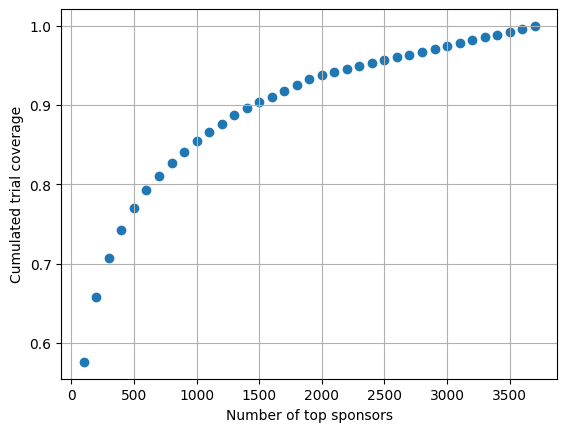

In [4]:
# ============ get top sponsors ============
import pandas as pd
import matplotlib.pyplot as plt

data_path = './CITT/'
sponsors = pd.read_csv(data_path + 'sponsors.txt', sep='|')
studies = pd.read_csv(data_path + 'studies.txt', sep='|', low_memory=False)
ticker_df = pd.read_csv('stock_price/ticker_dict_642.csv')

studies['study_first_submitted_date'] = pd.to_datetime(studies['study_first_submitted_date'])
sponsors = pd.merge(sponsors, studies[['nct_id', 'phase', 'study_first_submitted_date']], on='nct_id', how='left')
sponsors = sponsors[sponsors['agency_class']=='INDUSTRY']
sponsors.dropna(inplace=True)
sponsors = sponsors[sponsors['phase'].str.contains('Phase 3')]
# len(sponsors[sponsors['agency_class']=='INDUSTRY']['name'].unique()) #15277

# top sponsors and their cumulated trial coverage
num_sponsors = []
coverage = []
for i in range(100, len(sponsors['name'].unique()), 100):
    top_sponsors = sponsors['name'].value_counts().head(i)
    # print(top_sponsors.sum())
    coverage_ = top_sponsors.sum() / sponsors['name'].value_counts().sum()
    num_sponsors.append(i)
    coverage.append(coverage_)
plt.scatter(num_sponsors, coverage, label='Cumulated trial coverage')
plt.xlabel('Number of top sponsors')
plt.ylabel('Cumulated trial coverage')
plt.grid()

top_sponsors = sponsors['name'].value_counts().head(1000)
coverage_ = top_sponsors.sum() / sponsors['name'].value_counts().sum()
combined = pd.merge(top_sponsors.reset_index(), sponsors.groupby('name')['study_first_submitted_date'].min().reset_index(), on='name', how='left')
combined = pd.merge(combined, ticker_df, on='name', how='left')
print(combined.isna().sum())
print(combined.head())
# combined.to_csv('top_sponsors.csv', index=False)


In [ ]:
import zipfile
import json
import pandas as pd

# with zipfile.ZipFile('./fda_nat_drug_code_dir/ndctext.zip') as zf:
#     print(zf.namelist())
#     with zf.open("product.txt", mode="r") as file:
#         product = pd.read_csv(file, sep='\t', encoding='unicode_escape')
#     with zf.open("package.txt", mode="r") as file:
#         package = pd.read_csv(file, sep='\t', encoding='unicode_escape')
# with zipfile.ZipFile('./fda_nat_drug_code_dir/ndc_unfinished.zip') as zf:
#     print(zf.namelist())
#     with zf.open("unfinished_product.txt", mode="r") as file:
#         product2 = pd.read_csv(file, sep='\t', encoding='unicode_escape')
#     with zf.open("unfinished_package.txt", mode="r") as file:
#         package2 = pd.read_csv(file, sep='\t', encoding='unicode_escape')
# with zipfile.ZipFile('./fda_nat_drug_code_dir/ndc_excluded.zip') as zf:
#     print(zf.namelist())
#     with zf.open("Products_excluded.txt", mode="r") as file:
#         product3 = pd.read_csv(file, sep='\t', encoding='unicode_escape')
#     with zf.open("Packages_excluded.txt", mode="r") as file:
#         package3 = pd.read_csv(file, sep='\t', encoding='unicode_escape')
# with zipfile.ZipFile('./fda_nat_drug_code_dir/compounders_ndc_directory.zip') as zf:
#     print(zf.namelist())
#     with zf.open("compounders_ndc_directory.txt", mode="r") as file:
#         product4 = pd.read_csv(file, sep='\t', encoding='unicode_escape')

with zipfile.ZipFile('./openfda/drug-ndc-0001-of-0001.json.zip') as zf:
    with zf.open("drug-ndc-0001-of-0001.json") as f:
        data = json.load(f)
prod_ndc_dict = pd.DataFrame(data['results']).astype(str)
orange_book = pd.read_csv('./EOBZIP_2024_04/products.txt', sep='~').astype(str)

# remove nonnumeric from application number
prod_ndc_dict['application_number'] = prod_ndc_dict['application_number'].str.replace(r'\D', '', regex=True)

# results = ['Marketing Category, Total, # In Orange Book']
print('Marketing Category, Total, # In Orange Book')
for marketing_category in prod_ndc_dict['marketing_category'].unique():
    a = set(prod_ndc_dict[prod_ndc_dict['marketing_category']==marketing_category]['application_number'])
    # check lenth of overlap with orange book
    l = len([a_ for a_ in a if a_ in set(orange_book['Appl_No'])])
    print(f"{marketing_category}, {len(prod_ndc_dict[prod_ndc_dict['marketing_category']==marketing_category])}, {l}")

In [ ]:
# with zipfile.ZipFile('./ctod_data.zip') as zf:
#     train_df = pd.read_csv(zf.open('ctod_data/CTOD_train.csv'))
#     valid_df = pd.read_csv(zf.open('ctod_data/CTOD_valid.csv'))
#     test_df = pd.read_csv(zf.open('ctod_data/CTOD_test.csv'))
# all_dfs = pd.concat([train_df, valid_df, test_df])

# studies = pd.read_csv("./CITT/studies.txt", sep='|')
# studies['start_date'] = pd.to_datetime(studies['start_date'])
# studies['completion_date'] = pd.to_datetime(studies['completion_date'])
# studies.rename(columns={'nct_id': 'nctid'}, inplace=True)

# all_dfs = pd.merge(all_dfs, studies[['nctid', 'start_date', 'completion_date']], on='nctid', how='left')

# # split 1
# train_df = all_dfs[all_dfs['completion_date'] <  pd.to_datetime('2018-01-01')]
# valid_df = train_df.sample(frac=0.2, random_state=0, replace=False).reset_index(drop=True) # random sample 20% of the data for validation
# train_df = train_df[~train_df['nctid'].isin(valid_df['nctid'])].reset_index(drop=True)
# test_df = all_dfs[(all_dfs['completion_date'] >= pd.to_datetime('2018-01-01')) & (all_dfs['completion_date'] < pd.to_datetime('2020-01-01'))]
# print(train_df.shape, valid_df.shape, test_df.shape)
# # save as split 1
# train_df.to_csv('./CTOD_splits/train_pre2020.csv', index=False)
# valid_df.to_csv('./CTOD_splits/valid_pre2020.csv', index=False)
# test_df.to_csv('./CTOD_splits/test_pre2020.csv', index=False)

# # split 2
# train_df = all_dfs[all_dfs['completion_date'] <  pd.to_datetime('2020-01-01')]
# valid_df = train_df.sample(frac=0.2, random_state=0, replace=False).reset_index(drop=True) # random sample 20% of the data for validation
# train_df = train_df[~train_df['nctid'].isin(valid_df['nctid'])].reset_index(drop=True)
# test_df = all_dfs[(all_dfs['completion_date'] >= pd.to_datetime('2020-01-01')) & (all_dfs['completion_date'] < pd.to_datetime('2024-01-01'))]
# print(train_df.shape, valid_df.shape, test_df.shape)

# # save as split 2
# train_df.to_csv('./CTOD_splits/train_post2020.csv', index=False)
# valid_df.to_csv('./CTOD_splits/valid_post2020.csv', index=False)
# test_df.to_csv('./CTOD_splits/test_post2020.csv', index=False)

In [ ]:
# # ================== overlap between drugbank and orangebook ==================
# import pandas as pd
# # df = pd.read_csv('./drugbank_all_drug_links.csv.zip')
# drugbank_approved = pd.read_csv('./drugbank/drugbank_approved_drug_links.csv.zip')

# # exclusivity = pd.read_csv('./EOBZIP_2024_02/exclusivity.txt', sep='~')
# # patent = pd.read_csv('./EOBZIP_2024_02/patent.txt', sep='~')
# products = pd.read_csv('./EOBZIP_2024_02/products.txt', sep='~')
# drug_vocab = pd.read_csv('./drugbank/drugbank vocabulary.csv')

# drugbank_approved['Name'] = drugbank_approved['Name'].str.lower()
# drugbank_approved_names = set(drugbank_approved['Name'].unique())

# products[['Ingredient', 'Trade_Name']] = products[['Ingredient', 'Trade_Name']].apply(lambda x: x.str.lower().str.strip())
# products['Ingredient'] = products['Ingredient'].str.split(';')
# products['Ingredient'] = products['Ingredient'].apply(lambda x: [y.strip() for y in x] if isinstance(x, list) else [])
# unique_ingredients = set(products['Ingredient'].explode().unique())

# products['Trade_Name'] = products['Trade_Name'].str.split(' and ')
# products['Trade_Name'] = products['Trade_Name'].apply(lambda x: [y.strip() for y in x] if isinstance(x, list) else [])
# unique_trade_names = set(products['Trade_Name'].explode().unique())

# drug_vocab['Synonyms'] = drug_vocab['Synonyms'].str.split('|')
# drug_vocab['Synonyms'] = drug_vocab['Synonyms'].apply(lambda x: [y.lower().strip() for y in x] if isinstance(x, list) else [])

# all_synonyms = set(drug_vocab['Synonyms'].explode().dropna().unique())
# common_names = set(drug_vocab['Common name'].str.lower().unique())
# all_names = common_names.union(all_synonyms)

# print('unique_ingredients', len(unique_ingredients)) # 2264
# print(len(unique_ingredients.intersection(all_synonyms))) # 1088
# print(len(unique_ingredients.intersection(common_names))) # 1095
# print(len(unique_ingredients.intersection(all_names))) # 1183

# print('unique_trade_names', len(unique_trade_names)) # 7071
# print(len(unique_trade_names.intersection(all_synonyms))) # 669
# print(len(unique_trade_names.intersection(common_names))) # 629
# print(len(unique_trade_names.intersection(all_names))) # 701

# print('drugbank_approved_names', len(drugbank_approved_names)) # 4389
# print(len(drugbank_approved_names.intersection(unique_ingredients))) # 1074
# print(len(drugbank_approved_names.intersection(unique_trade_names))) # 624

In [ ]:
# import sys
# sys.path.append('./GNews/')
# from gnews import GNews

# google_news = GNews()
# pakistan_news = google_news.get_news('Pakistan')
# print(pakistan_news[0])    


In [ ]:
# import yfinance as yf

# msft = yf.Ticker("MSFT")

# # get all stock info
# msft.info

# # get historical market data
# hist = msft.history(period="1mo")

# # show meta information about the history (requires history() to be called first)
# msft.history_metadata

# # show actions (dividends, splits, capital gains)
# msft.actions
# msft.dividends
# msft.splits
# msft.capital_gains  # only for mutual funds & etfs

# # show share count
# msft.get_shares_full(start="2022-01-01", end=None)

# # show financials:
# # - income statement
# msft.income_stmt
# msft.quarterly_income_stmt
# # - balance sheet
# msft.balance_sheet
# msft.quarterly_balance_sheet
# # - cash flow statement
# msft.cashflow
# msft.quarterly_cashflow
# # see `Ticker.get_income_stmt()` for more options

# # # show holders
# # msft.major_holders
# # msft.institutional_holders
# # msft.mutualfund_holders
# # msft.insider_transactions
# # msft.insider_purchases
# # msft.insider_roster_holders

# # # show recommendations
# # msft.recommendations
# # msft.recommendations_summary
# # msft.upgrades_downgrades

# # Show future and historic earnings dates, returns at most next 4 quarters and last 8 quarters by default. 
# # Note: If more are needed use msft.get_earnings_dates(limit=XX) with increased limit argument.
# msft.earnings_dates

# # # show ISIN code - *experimental*
# # # ISIN = International Securities Identification Number
# # msft.isin

# # # show options expirations
# # msft.options

# # # show news
# # msft.news

# # # get option chain for specific expiration
# # opt = msft.option_chain('YYYY-MM-DD')
# # # data available via: opt.calls, opt.puts

In [ ]:
# import requests # doesn't work
# def get_ticker(company_name):
#     res = requests.get(url="https://query2.finance.yahoo.com/v1/finance/search", 
#                        params={
#                            "q": company_name, 
#                            }, 
#                        headers={
#                            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
#                            }
#                            )
#     data = res.json()
#     return data
#     # print(data)
#     # company_code = data['quotes'][0]['symbol']
#     # return company_code

# data = get_ticker('')
# data.keys() #dict_keys(['explains', 'count', 'quotes', 'news', 'nav', 'lists', 'researchReports', 'screenerFieldResults', 'totalTime', 'timeTakenForQuotes', 'timeTakenForNews', 'timeTakenForAlgowatchlist', 'timeTakenForPredefinedScreener', 'timeTakenForCrunchbase', 'timeTakenForNav', 'timeTakenForResearchReports', 'timeTakenForScreenerField', 'timeTakenForCulturalAssets'])


In [ ]:
# import json

# # with open("./tmp/NCT00102336_pubmed_abs.json", 'r') as f:
# with open("./tmp/NCT00102336_pubmed_abs.json", 'r') as f:
#     d = json.load(f)

# # print(len(d['References']))
# # print(d['References'][0].keys())
# # for i in range(len(d['References'])):
# #     print(i, d['References'][i]['Reference type'])

# prompt = '''
# You are given the PubMed abstract for a clinical trial. Your task is to use summarize important values of the trial into a json format. After summarization, you must predict the trial outcome.

# Guidelines:
# - **Completeness**: Ensure there are no missing statistical tests and descriptions in json output.
# - **Data Verification**: Before concluding the final answer, always verify that your observations align with the original trial description. Do not create any new information.

# Output Format:
# {
#     "description": <string of text summary of the trial outcome>,
#     "extracted features": [
#         {
#         "description: <string, text describing the feature extracted: e.g. "platelet response", "number of participants", "confidence interval", "p-value", "number", "study design">
#         "value": <float or string of the values of above description>
#         }, ... # can repeat as many times as needed
#     ]
#     "outcome": <string, must either "succeed", "fail", "unsure">,
#     "outcome reasoning": <string, reasoning as to why you predicted the outcome. Most trials succeed if the primary p-value < 0.05>
# }

# Notes for final output:
# - Ensure the final answer format is a valid json dictionary. 
# - Ensure all "value" are of float or string ONLY  

# Here is the abstract: 

# [ABSTRACT]

# Begin!
# '''

# abs = d['References'][5]['Abstract']

# print(prompt.replace("[ABSTRACT]", abs))
# # print(prompt)